# Analyze A/B Test Results 


- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability



In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#setting to seed to match the project requirement
random.seed(42)

### ToDo 1.1
Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
#import ab_data dataset and display the first 5 rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
#find number of column and rows from the imported file
df.shape

(294478, 5)

There are 294,478 rows and 5 columns in the datafile

**c.** The number of unique users in the dataset.

In [4]:
#find the number of unique values in each column
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

There are 290,584 unique users in the datafile

**d.** The proportion of users converted.

In [5]:
df[df.converted == 1].user_id.count()/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
#find rows that have the value "treatment" in column 'group' and rows that don't have the value "new_page" in the column 'landing_page'
df[(df.landing_page == 'new_page') & (df.group != 'treatment')].user_id.count() + df[(df.landing_page != 'new_page') & (df.group == 'treatment')].user_id.count()

3893

There are 3,893 rows that matches this filter

**f.** Do any of the rows have missing values?

In [7]:
#check if any rows have missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No rows have missing values

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Store the rows that didn't match the filter into a new dataframe called 'df2'
df2 = df.drop(df[((df.landing_page == 'new_page') & (df.group != 'treatment')) | ((df.landing_page != 'new_page') & (df.group == 'treatment'))].index)

In [9]:
# check to see if the new df2 column group contains 'treatment' or landing_page contains 'new_page'
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [10]:
#find count of unique rows in user_id
df2.user_id.nunique()

290584

There are 290,584 unique user_id

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
#find duplicates
df2.user_id[df2.user_id.duplicated(keep=False)]

1899    773192
2893    773192
Name: user_id, dtype: int64

user_id 773192 is a duplicate

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
#display rows where user_id 773192
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

Since the unique identifier here is the timestamp, we will use that to remove one of the duplicates

In [13]:
#remove 1 duplicate
df2 = df2[df2.timestamp != '2017-01-14 02:55:59.590927']

In [14]:
#check to see if duplicates are removed
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


The duplicate table is empty, meaning the remove duplicate code worked.

In [15]:
#check the unique user_id column again to see if it matches the previous query
df2.user_id.nunique()

290584

### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [16]:
#get the mean
df2.describe().loc['mean'].converted

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
#get the mean where group is 'control'
conv_control = df2.converted[df2.group == 'control'].mean()
conv_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
#get the mean where group is 'treatment'
conv_treat = df2.converted[df2.group == 'treatment'].mean()
conv_treat

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = conv_treat - conv_control
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
#find probability if landing_page is 'new_page'
df2[df2.landing_page == 'new_page'].count()/df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

The observation difference between the treatment and control group is very minimal (.0015) difference.

The probability of a user receiving a new page is .50, which says that they will receive the new page or old page, almost equally.

Based on the experiment above, I cannot say we can be confident that individuals will be converted based on a page.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

* Null Hypothesis: The probability of the new page has a higher chance of converting users at a Type I error rate of 5%
* Alternative Hypothesis: The probability of the old page has a higher chance of converting users if p-value is less than 0.05

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

In [21]:
#display df2 table
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [40]:
#assign new variable p_new (new probability) to the df2 dataframe converted mean and display the mean
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [41]:
#assign new variable p_old (old probability) to the df2 dataframe converted mean and display the mean
p_old = df2.converted.mean()
p_old

0.11959708724499628

In [42]:
#check to see the difference between p_new and p_old
p_new - p_old

0.0

There is no difference with the old or new page

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [43]:
#count number of individuals in treatment group
n_new = df2[df2.group == 'treatment'].count()[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [44]:
#count number of individuals in control group
n_old = df2[df2.group == 'control'].count()[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [27]:
#use numpy random choice to generate sample from p_new with size of n_new
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1 - p_new), p_new])
new_page_converted.mean()

0.11868419241621361

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [28]:
#use numpy random choice to generate sample from p_old with size of n_old
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1 - p_old), p_old])
old_page_converted.mean()

0.11999394248110468

In [51]:
#check p_new=p_old
p_new - p_old

0.0

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [48]:
#alternative
p_new2 = new_page_converted.mean()
p_old2 = old_page_converted.mean()
p_new2 - p_old2

-0.00029811123041335874


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [54]:
#Sample distribution through 10,000 iterations
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new,n_new)
    old_page_converted = np.random.binomial(1, p_old,n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

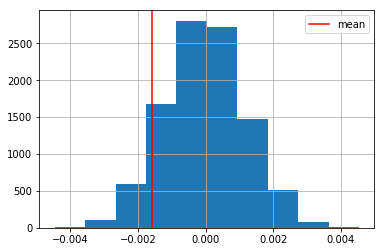

In [55]:
p_diffs = np.array(p_diffs)

#create histogram
plt.hist(p_diffs)
plt.grid()
plt.axvline(obs_diff, color='r', label='mean')
plt.legend();

In [56]:
#alternative: sample distribution through 10,000 iterations with new p_new2 and p_old2
p_diffs2 = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p_new2,n_new)
    old_page_converted = np.random.binomial(1, p_old2,n_old)
    p_diffs2.append(new_page_converted.mean() - old_page_converted.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

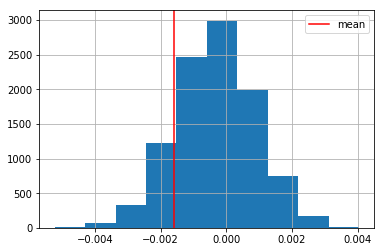

In [61]:
#alternative histogram
p_diffs2 = np.array(p_diffs2)

#create histogram
plt.hist(p_diffs2)
plt.grid()
plt.axvline(obs_diff, color='r', label='mean')
plt.legend();

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [58]:
#find proportion
(obs_diff < p_diffs).mean()

0.90369999999999995

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

The value that we calculated is called a p-value in scientistic studies. In null hypothesis significance testing, the p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct.

In order to reject the null hypothesis, the p-value should be below 0.05. Our p-value is above 0.05, which is too high to reject. Overall, we can't say there's a difference between the old page and new page.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [59]:
#display numbers of converted old and new page and individuals who were shown the old and new page

convert_old = df2[df2.group == 'control'].converted.sum()
convert_new = df2[df2.group == 'treatment'].converted.sum()
n_old = df2[df2.group == 'control'].converted.count()
n_new = df2[df2.group == 'treatment'].converted.count()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.


In [60]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new][::-1], [n_old, n_new], alternative='larger')
print(z_score, p_value)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


-1.26169574219 0.896470855197


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


The z-score is the standard deviation from our mean. Since our z-score is negative, it is saying that our data is on the left side of the mean line.

The p-value we calculated here is close to what we calculated earlier and still above 0.05, therefore, we cannot reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?


I will use logistic regression in this case.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [47]:
df2['intercept'] = 1
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page']) #create new columns ab_page and old_page
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [48]:
#assign logit_mod to logistic regression using statsmodels and fit model
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [49]:
#print summary
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-11-16 20:15 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

The z-score is the same as in step m. The p-value calculated here is 0.190 which is different because logistic regression is based on a two-tailed test. 0.190 is still greater then 0.05 (our $\alpha$), so we still cannot reject our null hypothesis. So far the outcome can still go either way.



**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

There are definitely other things that may influence converts, such as: Gender, Language, and Age Group. Since our current model has shown no signficant impact based on the old or new page, we should bring other factors in. There shouldn't be any disadvantages to this as it should help finding out if another variable has an impact on the model.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [50]:
# read file and join the dfs
countries_df = pd.read_csv('./countries.csv')
df_merged = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [51]:
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


In [52]:
df_merged.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [53]:
# Join with the df2 dataframe

In [54]:
df_merged[['canada','uk','us']] = pd.get_dummies(df_merged['country'])

In [64]:
# fitting linear model
df_merged['intercept'] = 1
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','canada','uk']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [65]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-11-16 20:21 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
canada       -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
uk            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

The p-values for the countries are above 0.05.

The ab_page p_value is still above 0.05 (very close to the value before adding in the confounding factors), we cannot reject the null hypothesis. 

Countries have no significant effect on the conversion.

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [58]:
#create new columns based on country and page
df_merged['canada_page'] = df_merged['canada'] * df_merged['ab_page']
df_merged['uk_page'] = df_merged['uk'] * df_merged['ab_page']

In [59]:
#display table with new columns
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,old_page,canada,uk,us,canada_page,uk_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0,0,1


In [60]:
#fit model
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'canada', 'uk', 'canada_page', 'uk_page']])
result = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [61]:
#display summary
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-11-16 20:16 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
canada       -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
uk           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
canada_page  -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
uk_page       0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

All the p-values that we calculated are above 0.05. 

ab_page p-value is still above 0.05 but a little less than the previous model but it is still above 0.05 so we still can't reject the null hypothesis

We can say that countries and pages has no significant effect on the conversion.

## Conclusions

Based on the above experiment, it suggests that there are not enough evidence to show that showing the new page would result in more conversions than the old page.


Overall, I would suggest the company save their money and resources on another implementation.

## Resources
* https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
* https://www.statology.org/z-score-python/
* https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
* https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob
* https://devdocs.io/statsmodels/

In [62]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0